In [ ]:
from helpers import *
import numpy as np 
import matplotlib.pyplot as plt
import pickle
from statsmodels.stats.multitest import multipletests

In [ ]:
### plot PV and spatial correlations for 2D simulations and compute statistics

outputs = {}
for condition in ['exp', 'cont']:
    act_maps = {}
    for out in ['F1', 'F2', 'N1', 'F3', 'N2']:
        with open(f'simulations/data/2d/{condition}_{out}.pkl', 'rb') as f:
            act_map = pickle.load(f)
        act_maps[out] = act_map

    outputs[condition] = act_maps

act_maps_exp = outputs['exp']
act_maps_cont = outputs['cont']

fig, axes = plt.subplots(3, 4, figsize=(16, 12), dpi=600)

act_maps_exp, act_maps_cont = smooth_act_maps(act_maps_exp, act_maps_cont, sigma=1)

all_ps = []
results = {}

for i, (out1, out2) in enumerate([('F1', 'F2'), ('F2', 'N1'), ('N1', 'N2')]):
    axs = axes[i, :]

    axs[0].set_ylabel('experimental', fontsize=20)
    axs[1].set_ylabel('control', fontsize=20)

    plot_cross_correlogram(act_maps_exp, out1, out2, title=f'{out1} vs {out2}', ax=axs[0], sigma = 1.5)
    plot_cross_correlogram(act_maps_cont, out1, out2, title=f'{out1} vs {out2}', ax=axs[1], sigma = 1.5)
    sp_exp = cor_act_maps_2d(act_maps_exp[out1], act_maps_exp[out2], which='spatial')
    sp_cont = cor_act_maps_2d(act_maps_cont[out1], act_maps_cont[out2], which='spatial')

    stat_sp, p_sp = ks_2samp(sp_exp, sp_cont)
    was_d_sp = wasserstein_distance(sp_exp, sp_cont)
    all_ps.append(p_sp)

    create_raincloud_plot((sp_exp, sp_cont), out1, out2, ax=axs[2], p=(p_sp,),
                            colors=(COLOR_SETTINGS['exp_normal'], COLOR_SETTINGS['control_normal']))

    pv_exp = cor_act_maps_2d(act_maps_exp[out1], act_maps_exp[out2], which='pv')
    pv_cont = cor_act_maps_2d(act_maps_cont[out1], act_maps_cont[out2], which='pv')
    
    stat_pv, p_pv = ks_2samp(pv_exp, pv_cont)
    was_d_pv = wasserstein_distance(pv_exp, pv_cont)
    all_ps.append(p_pv)

    plot_pv_corr_distributions((pv_exp, pv_cont), out1, out2, ax=axs[3], p=(p_pv,),
                            colors=(COLOR_SETTINGS['exp_normal'], COLOR_SETTINGS['control_normal']))


    results[f'sp_{out1}_{out2}'] = (np.nanmean(sp_exp), np.nanstd(sp_exp), 
                                    np.nanmean(sp_cont), np.nanstd(sp_cont),
                                    stat_sp, p_sp, was_d_sp)
    

    results[f'pv_{out1}_{out2}'] = (np.nanmean(pv_exp), np.nanstd(pv_exp),
                                    np.nanmean(pv_cont), np.nanstd(pv_cont),
                                    stat_pv, p_pv, was_d_pv)


plt.tight_layout()
plt.show()

results = pd.DataFrame.from_dict(results, orient='index', columns=[
    'mean_exp', 'std_exp', 'mean_cont', 'std_cont', 'stat', 'p', 'was_d'])   

results['p'] = multipletests(all_ps, method='fdr_bh')[1]

for col in results.columns:
    results[col] = results[col].apply(format_val)

results.to_csv('results/fig6_results.csv')


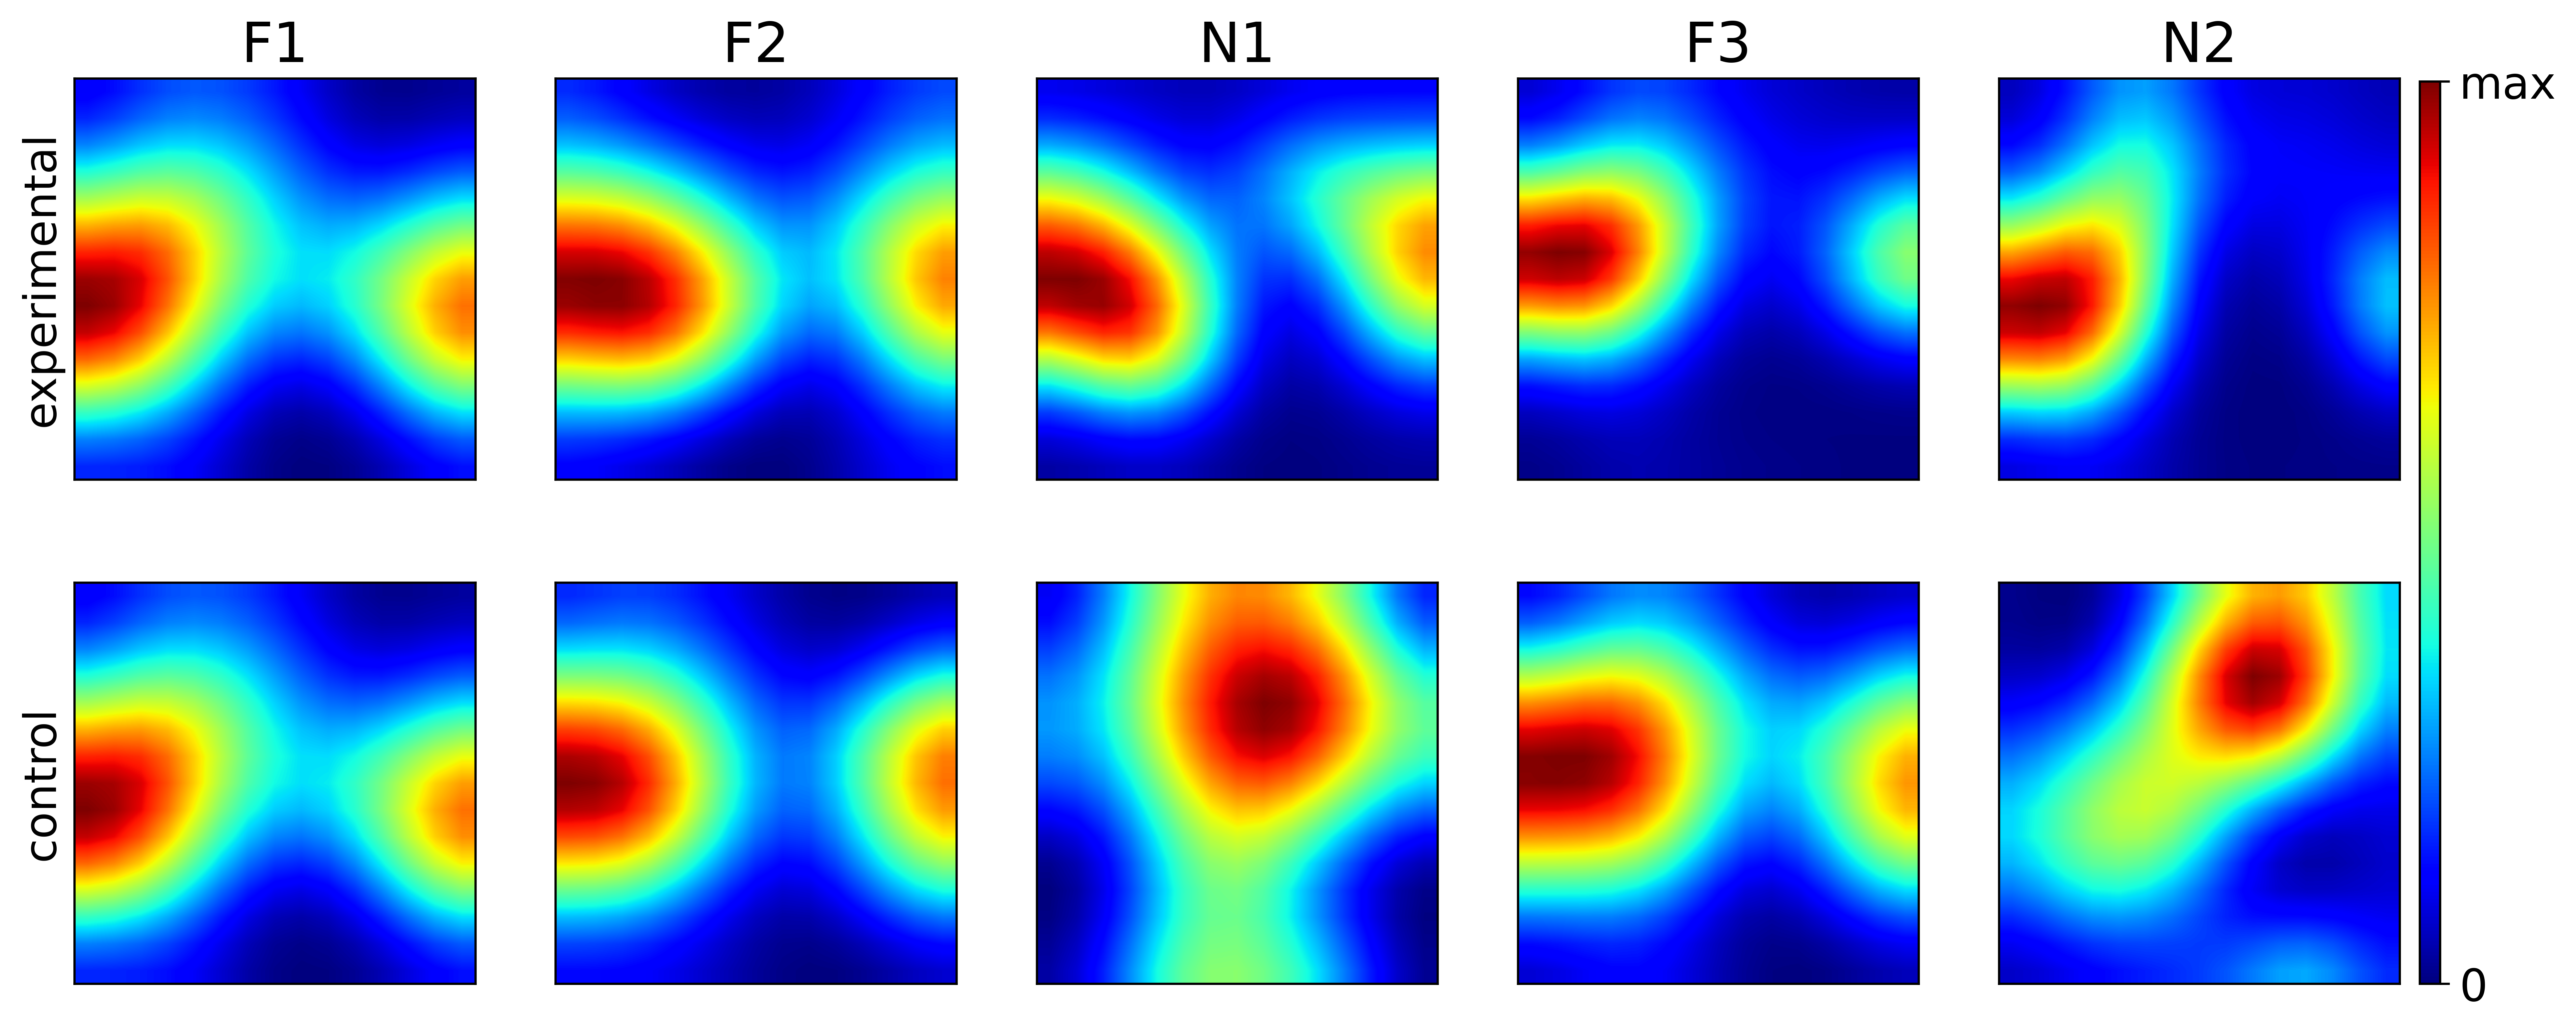

In [ ]:
### plot example cell over experimental conditions and stages

fig, axes = plt.subplots(2, 5, figsize=(15, 6), sharex=True, dpi=600)

for i, act_maps in enumerate([act_maps_exp, act_maps_cont]):
    axs = axes[i]
    axs[0].set_ylabel('experimental' if i == 0 else 'control', fontsize=16)
    
    for ax, out in zip(axs, act_maps.keys()):
        act_map = act_maps[out][248, :]
        title = out if i == 0 else None
        im = plot_one_2d_map(ax, act_map, title)

cbar_ax = ax.inset_axes([1.05, 0, 0.05, 2.25])
cbar = fig.colorbar(im, cax=cbar_ax)

# Only show 0 and max
vmin, vmax = im.get_clim()
cbar.set_ticks([vmin, vmax])
cbar.set_ticklabels([f"0", f"max"], fontsize = 16, rotation=0)